In [614]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона. done
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты. done
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

In [615]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [616]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

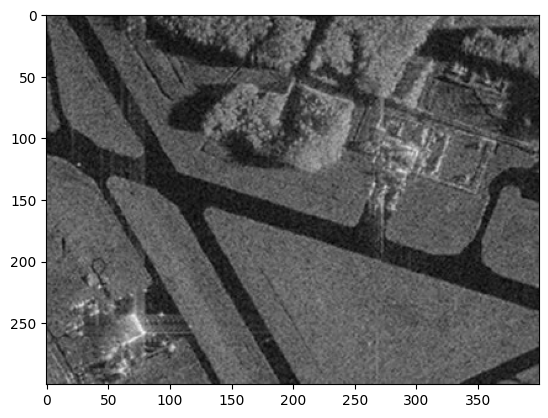

In [617]:
plt.imshow(image_gray, cmap="gray")

# Алгоритм разрастания регионов

Критерий однородности на основе среднего значения (представлен в примере)

In [618]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])

    if abs(av_val - img[point]) <= T:
        return True

    return False

In [619]:
def homo_variance(img, mask, point, T):
    region_pixels = img[mask > 0]
    mean_val = np.mean(region_pixels)
    std_val = np.std(region_pixels)
    return abs(mean_val - img[point]) <= T and std_val <= T * 1.5

Критерий однородности на основе медианы

In [620]:
def homo_median(img, mask, point, T):
    median = np.median(img[mask > 0])
    return abs(median - img[point]) <= T

In [621]:
def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        print(count)
        mask += local_mask

    return mask*255

Text(0.5, 1.0, 'Гамма=83.69823442391257')

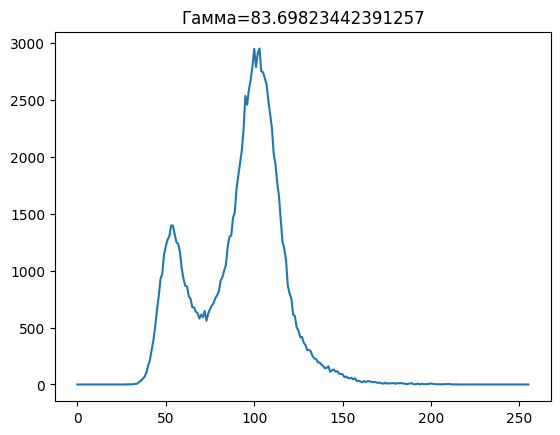

In [622]:
histSize = 256
histRange = (0, 256)
accumulate = False

hist = cv2.calcHist([image_gray], [0], None, [histSize], histRange, accumulate=accumulate)
plt.plot(hist)
mode_val = np.argmax(hist)
plt.title(f"Гамма={mode_val}")

import numpy as np

def simple_threshold(image, max_iter=100):
    T = (image.min() + image.max()) // 2  # Начальный порог
    for i in range(max_iter):
        # Разделяем пиксели по порогу
        m1 = np.mean(image[image < T])  # Среднее темных пикселей
        m2 = np.mean(image[image >= T]) # Среднее светлых пикселей

        new_T = (m1 + m2) / 2  # Новый порог

        # Если порог не меняется - выходим
        if abs(new_T - T) < 1:
            break

        T = new_T

    # Создаем бинарную маску
    mask = (image >= T).astype(np.uint8) * 255

    return T, mask
T, mask = simple_threshold(image_gray)
plt.title(f"Гамма={T}")

Критерий однородности на основе среднего значения

In [623]:
# seed_point = (100,100)
# mask = region_growing(image_gray,seed_point,homo_average,7, 19)

In [624]:
# plt.imshow(mask, cmap="gray")

In [625]:
#mask1 = region_growing(image_gray,seed_point,homo_variance,7, 19)

In [626]:
#plt.imshow(mask1, cmap="gray")

Критерий однородности на основе медианы

In [627]:
# mask2 = region_growing(image_gray,seed_point,homo_median,7, 19)
# plt.imshow(mask2, cmap="gray")

In [628]:
# plt.subplot(1,2,1)
# plt.imshow(mask, cmap="gray")
# plt.title("Среднее значение")
# plt.subplot(1,2,2)
# plt.title("Медиана")
# plt.imshow(mask2, cmap="gray")

# Watershed+Distance transform

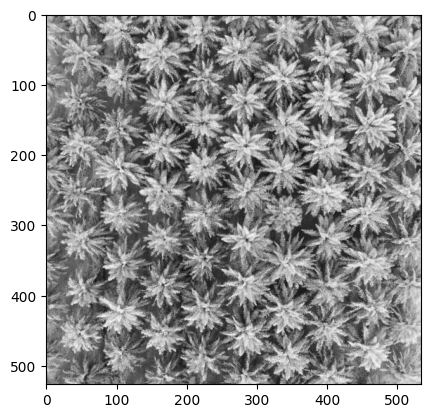

In [629]:
img = cv2.imread('palm_1.jpg')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray, cmap="gray")

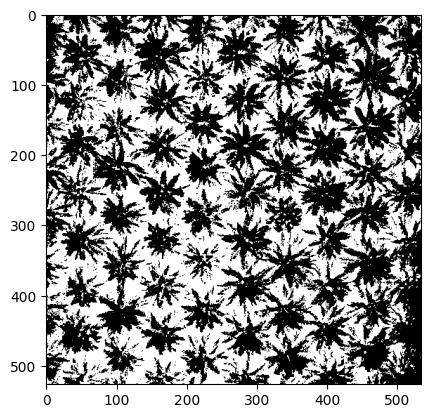

In [630]:
ret, thresh = cv2.threshold(img_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
plt.imshow(thresh, cmap="gray")

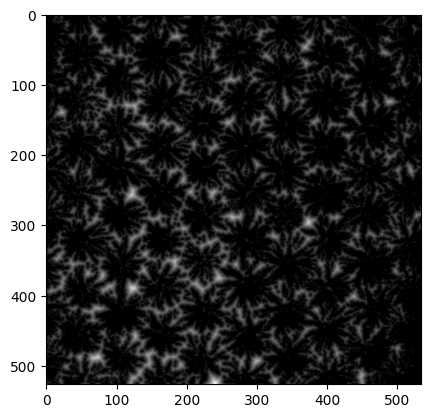

In [631]:
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
plt.imshow(dist, cmap="gray")

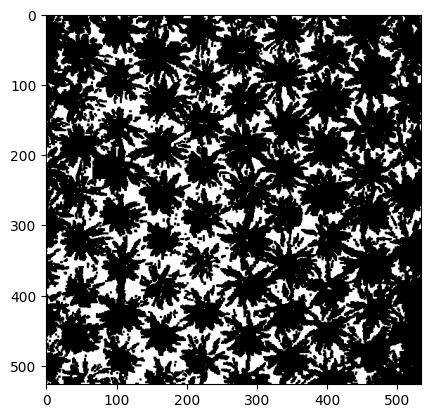

In [632]:
ret, sure_fg = cv2.threshold(dist, 0.1 * dist.max(), 255, cv2.THRESH_BINARY)
plt.imshow(sure_fg, cmap="gray")

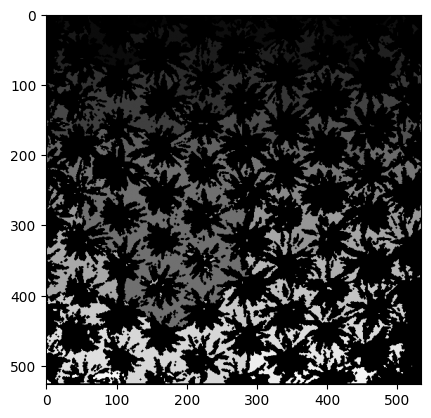

In [633]:
sure_fg = sure_fg.astype(np.uint8)
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
unknown = cv2.subtract(thresh, sure_fg)
markers[unknown == 255] = 0

markers = markers.astype(np.int32)

markers_result = cv2.watershed(img, markers)
plt.imshow(markers_result, cmap="gray")

In [634]:
markers = cv2.watershed(img, markers)

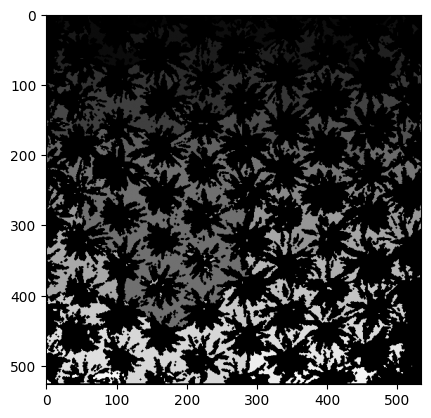

In [635]:
plt.imshow(markers, cmap="gray")